In [459]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv("process.csv")

data.describe()

,Unnamed: 0,x
count,526116.000000,526116.000000
mean,263058.500000,0.034148
std,151876.751449,6.265718
min,1.000000,-166.000000
25%,131529.750000,-2.000000
50%,263058.500000,0.000000
75%,394587.250000,2.000000
max,526116.000000,199.000000


Some features of the descriptive statistics:
- Median is exactly 0.0 but mean is 0.034 which is very close to 0.0.
- The absolute value of the first and third quartiles are equal.
- Probably the distribution of noise is symmetric around the median.
- There are obvious outliers.

I droped the outliers in the next step 

In [460]:
data[(data.x <= np.percentile(data.x, 75)) & (data.x >= np.percentile(data.x, 25))].describe()

,Unnamed: 0,x
count,291571.000000,291571.000000
mean,257388.811987,0.004641
std,153482.801556,0.896002
min,2.000000,-2.000000
25%,127515.500000,0.000000
50%,242292.000000,0.000000
75%,392077.000000,0.000000
max,526116.000000,2.000000


Here I consider only 50% of the time series. The first and third quartiles are equal to 0.0, indicating that the time series contains more than 25% 0.0, so I have droped the zeroes from the time series.


In [461]:
data[(data.x != 0.0)].describe()

,Unnamed: 0,x
count,357289.000000,357289.000000
mean,268334.646723,0.050283
std,152234.282010,7.603244
min,1.000000,-166.000000
25%,136297.000000,-3.300000
50%,272455.000000,0.200000
75%,401843.000000,3.500000
max,526116.000000,199.000000


The time series without 0.0 looks symmetric around the 0.0 since the value of median and mean are very close to the 0.0 and the absolute value of first and third quartiles are almost equal. To further study, I droped outliers and zeros from the noise and calculate mean and median. 

In [464]:
data[(data.x <= np.percentile(data.x, 75)) & (data.x >= np.percentile(data.x, 25)) & (data.x != 0.0)].describe()

,Unnamed: 0,x
count,122744.000000,122744.000000
mean,264948.552328,0.011024
std,157168.182919,1.380937
min,2.000000,-2.000000
25%,133926.750000,-1.000000
50%,239102.000000,0.100000
75%,412188.500000,1.000000
max,526116.000000,2.000000


In [465]:
data[(data.x <= np.percentile(data.x, 99)) & (data.x >= np.percentile(data.x, 1)) & (data.x != 0.0)].describe()

,Unnamed: 0,x
count,346783.000000,346783.000000
mean,267711.542065,0.049068
std,152989.562795,5.830099
min,1.000000,-18.800000
25%,134819.000000,-3.000000
50%,269459.000000,0.200000
75%,402347.500000,3.200000
max,526116.000000,18.500000


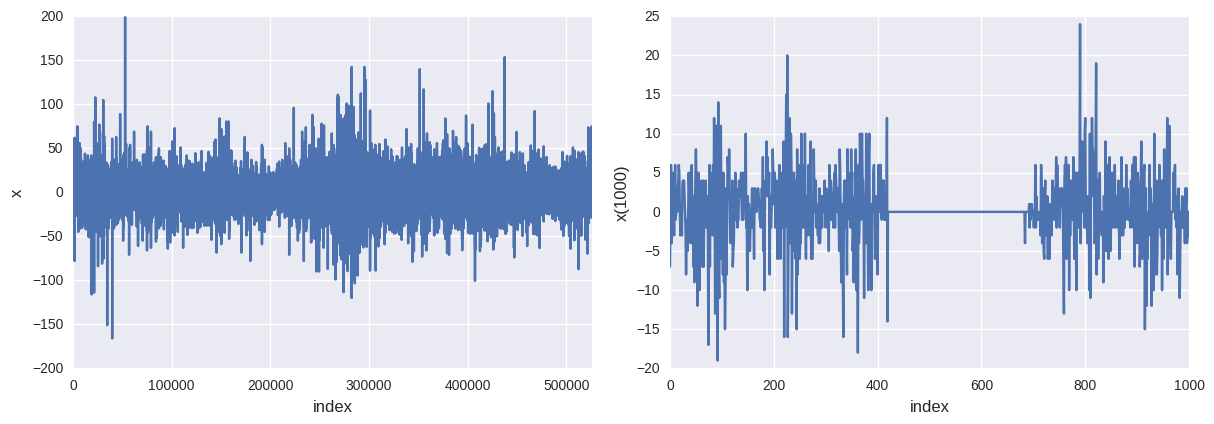

In [466]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.15)

axs[0].plot(data.loc[:,'x'])
axs[0].set_xlabel('index', fontsize=12)
axs[0].set_ylabel('x', fontsize=12)
axs[0].set_xlim([0,data.shape[0]])

axs[1].plot(data.loc[:1000,'x'])
axs[1].set_xlabel('index', fontsize=12)
axs[1].set_ylabel('x(1000)', fontsize=12)

Some features of the plots:
- There is no consistent trend (upward or downward) over the entire time span.
- There is no obvious repeating pattern as a function of time.
- There are some outliers.
- It is difficult to judge whether the variance is constant or not.
- There is an abrupt change in the time series which is obvious in figure 2

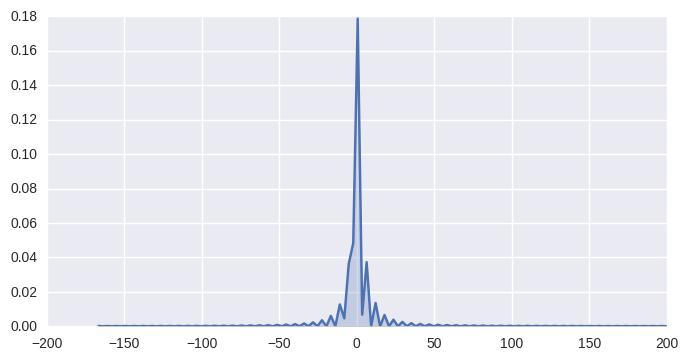

In [76]:
plt.figure(figsize=(8,4))
sns.kdeplot(data.x, shade=True, label="")

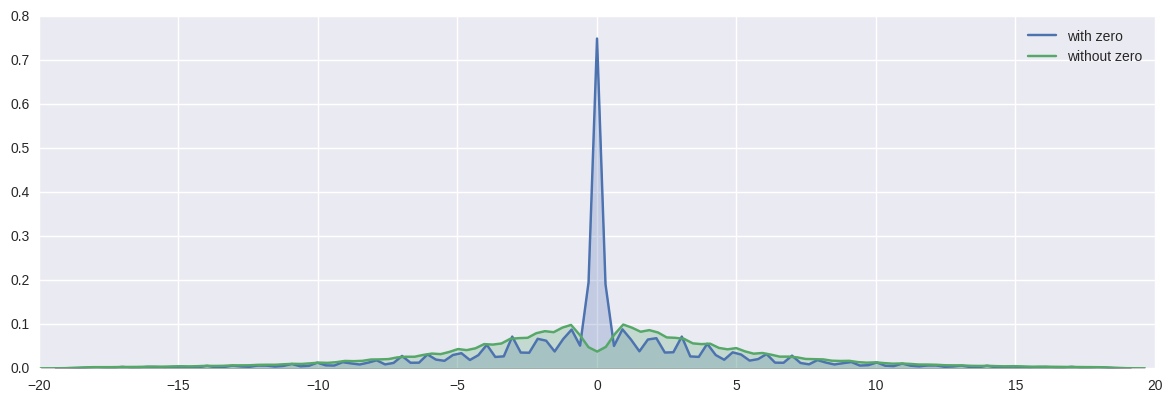

In [77]:
fig, axs = plt.subplots(ncols=1, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

sns.kdeplot(data[(data.x <= np.percentile(data.x, 99)) & (data.x >= np.percentile(data.x, 1))].x, shade=True, label="with zero", ax=axs)
sns.kdeplot(data[(data.x <= np.percentile(data.x, 99)) & (data.x >= np.percentile(data.x, 1)) & (data.x != 0.0)].x, shade=True, label="without zero", ax=axs)

The density plot has a sharp peak at 0.0.

I truncated the extreme values in the time series by using percentile function.

In [468]:
ulimit = np.percentile(data.x, 99)
llimit = np.percentile(data.x, 1)
print ulimit, llimit
data.loc[data.x>ulimit, 'x'] = ulimit
data.loc[data.x<llimit, 'x'] = llimit

18.5 -18.8


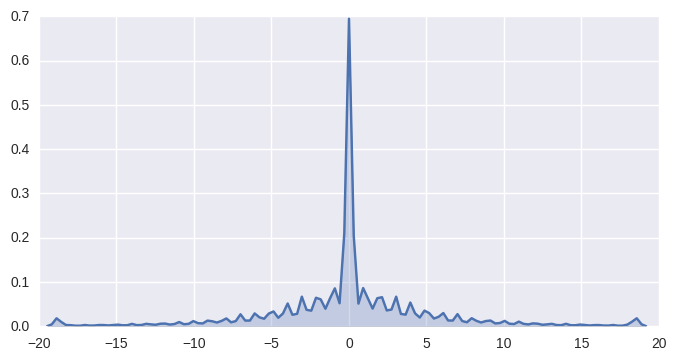

In [469]:
plt.figure(figsize=(8,4))
sns.kdeplot(data.x, shade=True, label="")

In [470]:
data.describe()

,Unnamed: 0,x
count,526116.000000,526116.000000
mean,263058.500000,0.028780
std,151876.751449,5.417672
min,1.000000,-18.800000
25%,131529.750000,-2.000000
50%,263058.500000,0.000000
75%,394587.250000,2.000000
max,526116.000000,18.500000


In [81]:
index = data.x == 0
print data.shape[0], index.sum(), float(index.sum())/data.shape[0]

526116 168827 0.320893111025


The time series contains 32% zeros. It seems the time series is a combination of a noise with normal distribution and some zero values. The zero values might show the missing value simillar to the sparse matrix. Based on the first Figure, it seems in a period or a cycle all values are zeros and they built a cluster contains only zero value. I wrote the code to find these clusters in the time series and return the posotion and size of the clusters. I also extract a noise without zero clusters from the time series and analysed the noise and zero clusters seperatly.   

In [471]:
print data.shape
arr = data["x"].as_matrix()
len(arr)

count = 0
zeros_start=[]; zeros_end=[]; zeros_len=[]
arr_new = np.array([])
for ii in range(1,len(arr)-1):
    if arr[ii] == 0 and (arr[ii-1]==0 or arr[ii+1]==0):
        count +=1
        if arr[ii-1]!=0 and arr[ii+1]==0:
            zeros_start.append(ii)
        elif arr[ii-1]==0 and arr[ii+1]!=0:
            zeros_end.append(ii)
    else:
        arr_new = np.append(arr_new, arr[ii])
print count
print len(arr_new)


(526116, 2)
149628
376486


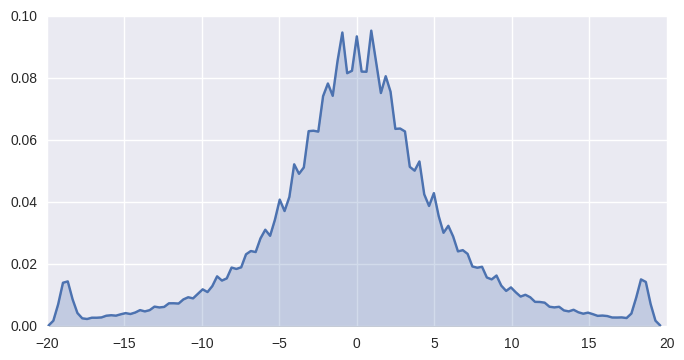

In [472]:
plt.figure(figsize=(8,4))
sns.kdeplot(arr_new, shade=True, label="")

The distribution of the noise extracted from time series as I expected is normal distribution. 

In [473]:
zeros_len=[]; zeros_pos=[]
for ii in range(len(zeros_start)):
    zeros_len.append(zeros_end[ii]-zeros_start[ii])
    zeros_pos.append((zeros_end[ii]+zeros_start[ii])/2)
    
print len(zeros_len)
print len(zeros_end)

2779
2779


(0, 20000)

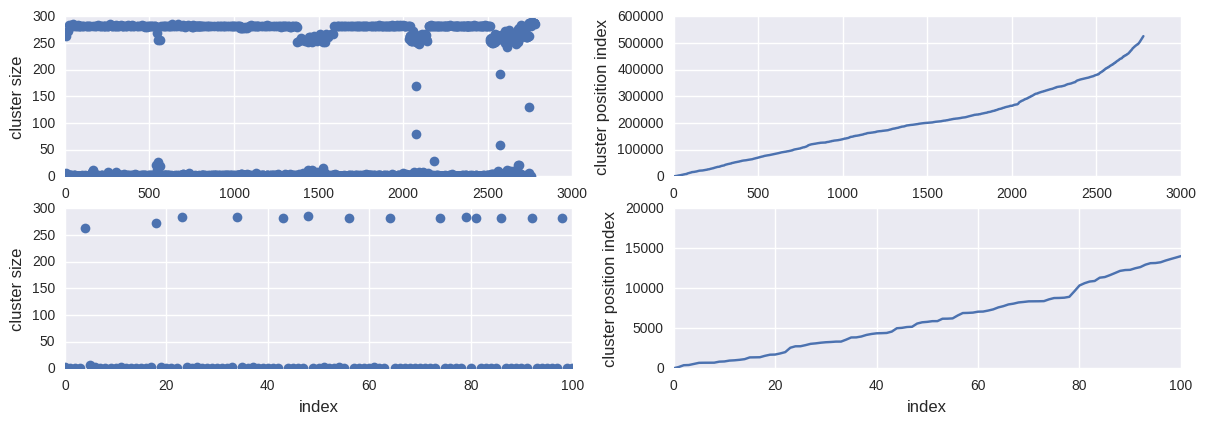

In [474]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=.2)

axs[0][0].plot(zeros_len, 'o')
axs[0][0].set_xlabel('index', fontsize=12)
axs[0][0].set_ylabel('cluster size', fontsize=12)

axs[0][1].plot(zeros_pos)
axs[0][1].set_xlabel('index', fontsize=12)
axs[0][1].set_ylabel('cluster position index', fontsize=12)

axs[1][0].plot(zeros_len, 'o')
axs[1][0].set_xlabel('index', fontsize=12)
axs[1][0].set_ylabel('cluster size', fontsize=12)
axs[1][0].set_xlim([0,100])

axs[1][1].plot(zeros_pos)
axs[1][1].set_xlabel('index', fontsize=12)
axs[1][1].set_ylabel('cluster position index', fontsize=12)
axs[1][1].set_xlim([0,100])
axs[1][1].set_ylim([0,20000])

Some features of the plots:
- There are small and large clusters
- 

In [224]:
zeros_len = np.asarray(zeros_len)
index_large = (zeros_len > 250).nonzero()
index_small = (zeros_len < 50).nonzero()
large = zeros_len[index_large]
small = zeros_len[index_small]
print "Number of cluster with size larger than 250" + str(len(large))
print "Number of cluster with size smaller than 50" + str(len(small))

Number of cluster with size larger than 250513
Number of cluster with size smaller than 502254


(0, 20000)

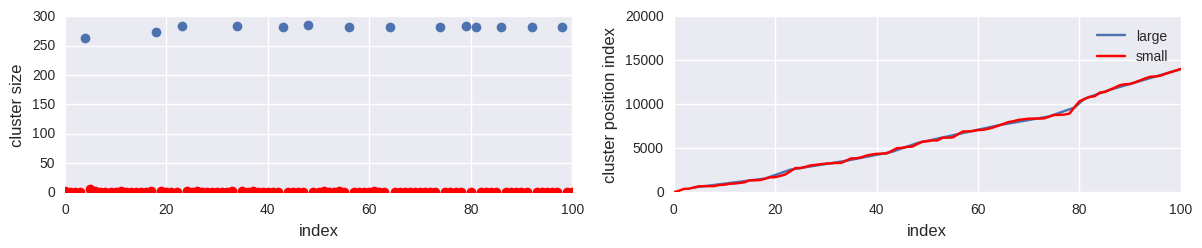

In [432]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 2))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)

axs[0].plot(index_large[0], large, 'o', index_small[0], small, 'ro')
axs[0].set_xlabel('index', fontsize=12)
axs[0].set_ylabel('cluster size', fontsize=12)
axs[0].set_xlim([0,100])

zeros_pos = np.asarray(zeros_pos)
pos_large = zeros_pos[index_large]
pos_small = zeros_pos[index_small]

axs[1].plot(index_large[0], pos_large, label='large')
axs[1].plot(index_small[0], pos_small, 'r', label='small')
axs[1].set_xlabel('index', fontsize=12)
axs[1].set_ylabel('cluster position index', fontsize=12)
axs[1].legend()
axs[1].set_xlim([0,100])
axs[1].set_ylim([0,20000])

In [391]:
fft_signal = np.fft.fft(zeros_len)
freq = np.fft.fftfreq(len(fft_signal))

In [392]:
freq_ind = np.arange(1, len(fft_signal)/2, dtype=int)
print np.allclose(f[freq_ind], -1 * f[-freq_ind]) # Make sure the Frequencies are mirrored

#calculate power spectral density
psd = np.abs(fft_signal[freq_ind])**2

True


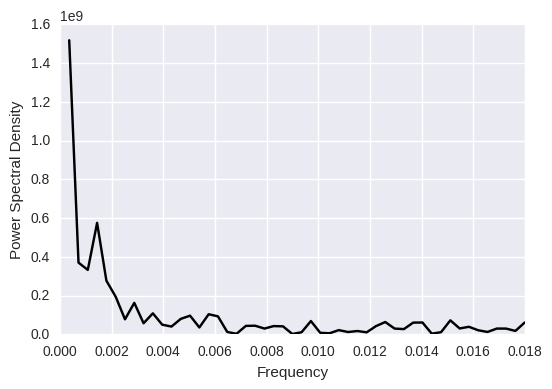

In [394]:
plt.figure()
plt.plot(freq[freq_ind[:50]], psd[:50], 'k-')
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.show()

In [233]:
data = pd.read_csv("process.csv")

index = data.x == 0.0

count = 0
for ii in range(1,index.shape[0]-1):
    if data.loc[ii].x == 0 and (data.loc[ii-1].x==0 or data.loc[ii+1].x==0):
        count +=1
        index[ii] = True
    else:
        index[ii] = False
        
print data.shape
print index.shape, index.sum()

(526116, 2)
(526116,) 149628


In [324]:
noise = data[~index].reset_index()["x"]
noise = noise.to_frame()
print noise.describe()

                   x
count  376488.000000
mean        0.047719
std         7.406852
min      -166.000000
25%        -3.000000
50%         0.000000
75%         3.000000
max       199.000000


In [325]:
def get_median_filtered(signal, threshold = 3):
    """
    signal: is numpy array-like
    returns: signal, numpy array 
    """
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    s = 0 if median_difference == 0 else difference / float(median_difference)
    mask = s > threshold
    signal[mask] = signal[mask] / threshold 
    return 



In [329]:
window_size = 100
noise["filtered"] = noise.x.values

for ii in range(0, noise.shape[0], window_size):
    get_median_filtered(noise[ii:ii+window_size].filtered.values) 

In [330]:
print noise.describe()

                   x       filtered
count  376488.000000  376488.000000
mean        0.047719       0.042891
std         7.406852       5.103690
min      -166.000000     -55.333333
25%        -3.000000      -3.000000
50%         0.000000       0.000000
75%         3.000000       3.000000
max       199.000000      66.333333


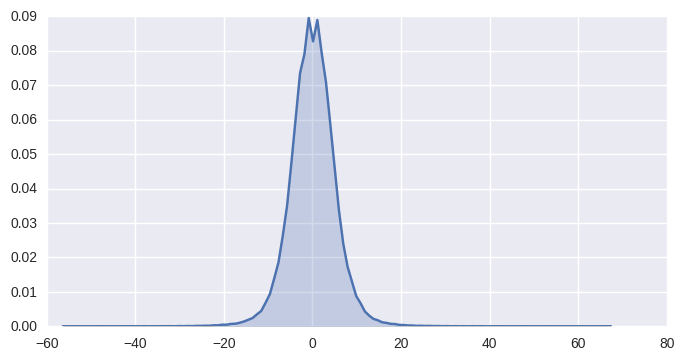

In [331]:
plt.figure(figsize=(8,4))
sns.kdeplot(noise.filtered, shade=True, label="")
#sns.kdeplot(noise.x, shade=True, label="")

In [337]:
window = noise[10000:11000].x
window.describe()

count    1000.000000
mean        0.552000
std         6.696876
min       -33.000000
25%        -3.000000
50%         0.000000
75%         4.000000
max        42.000000
Name: x, dtype: float64

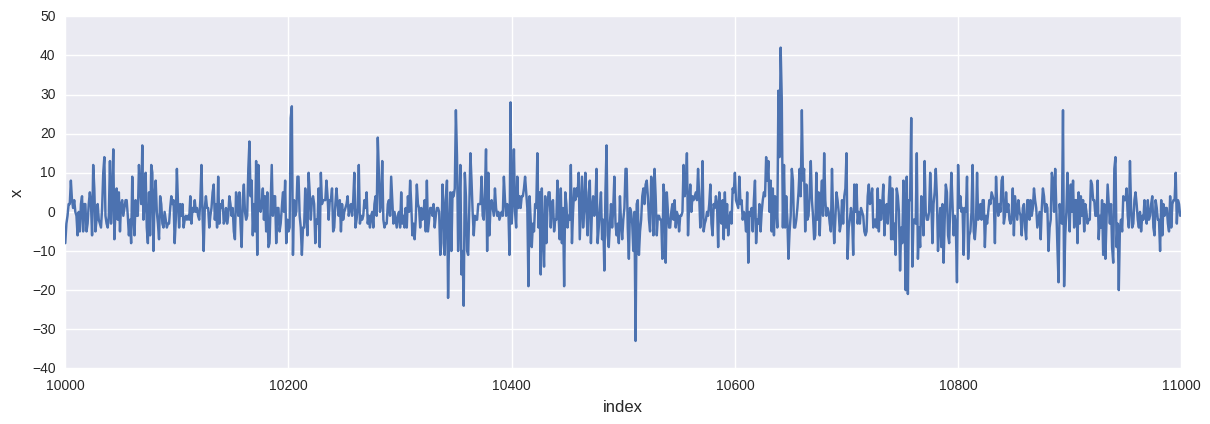

In [340]:
fig, axs = plt.subplots(ncols=1, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs.plot(window)
axs.set_xlabel('index', fontsize=12)
axs.set_ylabel('x', fontsize=12)

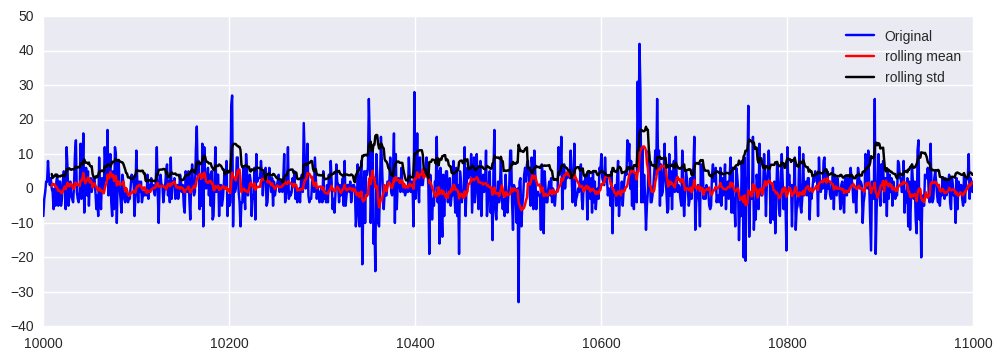

In [361]:
#from ipykernel import kernelapp as app
rolemean = window.rolling(window=10,center=False).mean()
rolestd = window.rolling(window=10,center=False).std()

fig, axs = plt.subplots(ncols=1, figsize=(12, 4))
axs.plot(window, 'b', label="Original")
axs.plot(rolemean, 'r', label="rolling mean")
axs.plot(rolestd, 'k', label="rolling std")
axs.legend()

In [362]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(window, autolag=None, maxlag=10)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print dfoutput
#The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

Test Statistic                -9.071028e+00
p-value                        4.301847e-15
#Lags Used                     1.000000e+01
Number of Observations Used    9.890000e+02
Critical Value (5%)           -2.864467e+00
Critical Value (1%)           -3.436979e+00
Critical Value (10%)          -2.568328e+00
dtype: float64


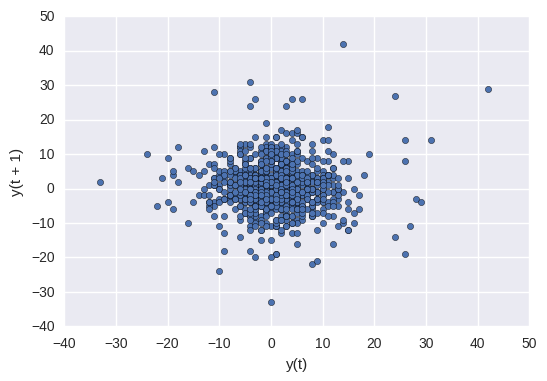

In [364]:
from pandas.tools.plotting import lag_plot
lag_plot(window)

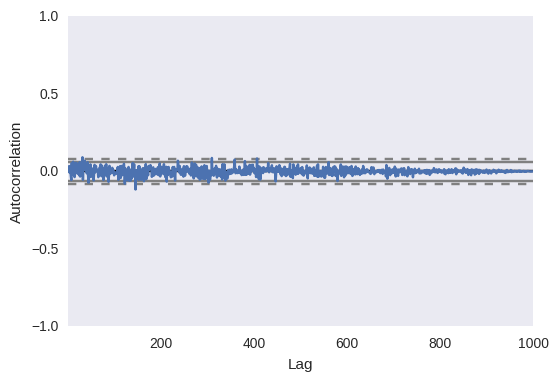

In [367]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(window)

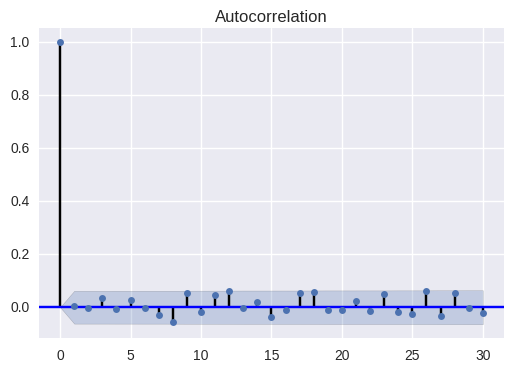

In [371]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(window, lags=30)
plt.show()

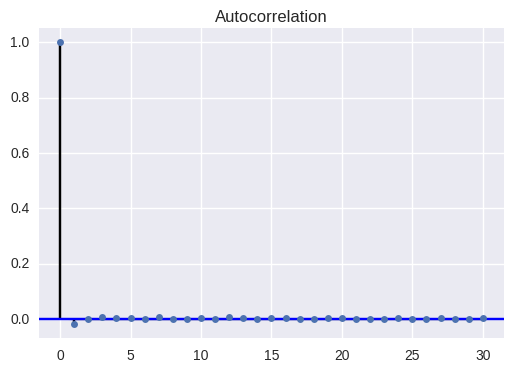

In [372]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(noise.x, lags=30)
plt.show()

In [373]:
np.std(noise.x)

7.406841938898498

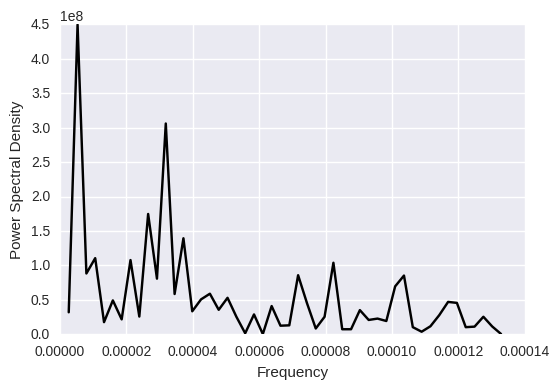

In [395]:
fft_signal = np.fft.fft(noise.x)
freq = np.fft.fftfreq(len(noise.x))

freq_ind = np.arange(1, len(fft_signal)/2, dtype=int)
#print np.allclose(f[freq_ind], -1 * f[-freq_ind]) # Make sure the Frequencies are mirrored

#calculate power spectral density
psd = np.abs(fft_signal[freq_ind])**2

plt.figure()
plt.plot(freq[freq_ind[:50]], psd[:50], 'k-')
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.show()

(-80.0, 80.0)

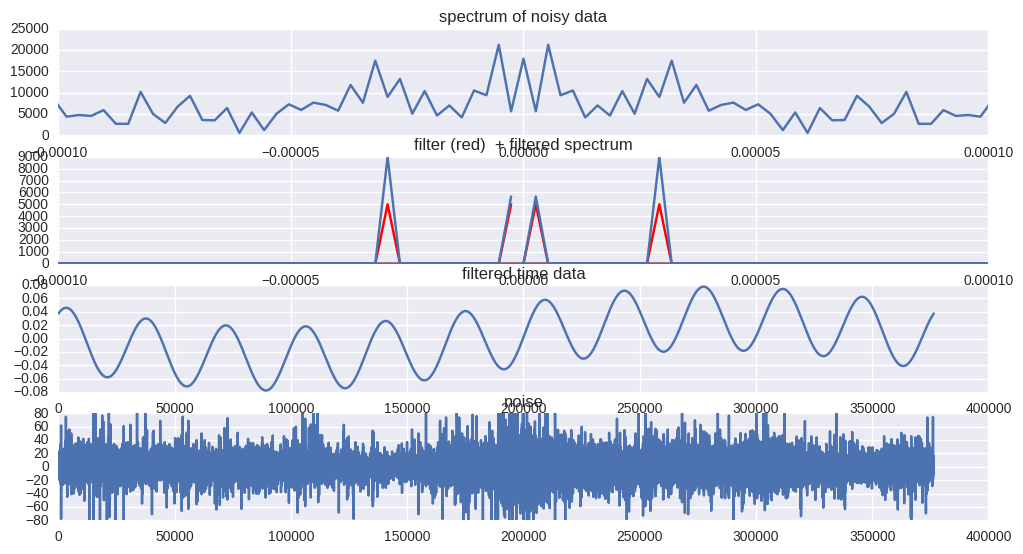

In [442]:
f1, f2 = freq[1], freq[11]
#make up a narrow bandpass with a Gaussian
df=0.0000001
gpl= np.exp(- ((freq-f1)/(2*df))**2)+ np.exp(- ((freq-f2)/(2*df))**2)  # pos. frequencies
gmn= np.exp(- ((freq+f1)/(2*df))**2)+ np.exp(- ((freq+f2)/(2*df))**2)  # neg. frequencies
g=gpl+gmn    
filt=fft_signal*g

plt.figure(figsize=(12,8))

plt.subplot(511)
plt.plot(np.fft.fftshift(freq) ,np.fft.fftshift(np.abs(fft_signal)))
plt.xlim([-0.0001,0.0001])
plt.title('spectrum of noisy data')

plt.subplot(512)
plt.plot(freq,g*5000, 'r')  
plt.plot(freq,np.abs(filt))
plt.xlim([-0.0001,0.0001])
plt.title('filter (red)  + filtered spectrum')

isignal = np.fft.ifft(filt)
plt.subplot(513)
plt.plot(np.real(isignal))
plt.title('filtered time data')

plt.subplot(514)
plt.plot(noise.x)
plt.title('noise')
plt.ylim([-80.,80.])

In [427]:
noise[50000:150000].describe()

,x,filtered
count,100000.000000,100000.000000
mean,0.022089,0.025451
std,5.468206,3.617679
min,-78.000000,-26.000000
25%,-2.500000,-2.333333
50%,0.000000,0.000000
75%,2.500000,2.500000
max,84.000000,28.000000


In [428]:
noise[250000:300000].describe()

,x,filtered
count,50000.000000,50000.000000
mean,0.126658,0.122637
std,8.184597,5.731112
min,-100.600000,-37.000000
25%,-4.000000,-3.900000
50%,0.000000,0.000000
75%,4.000000,4.000000
max,117.000000,39.000000


In [477]:
noise.x.value_counts().head(10)

-1.0    20940
 1.0    20898
 0.0    19199
 2.0    17282
-2.0    16717
 3.0    13131
-3.0    13090
 4.0    10206
-4.0     9778
 5.0     7399
Name: x, dtype: int64

In [478]:
index = data.x != 0 # drop zeros
noise = data[index].reset_index()["x"]

noise[noise > 0] = 1
noise[noise < 0] = -1
noise.value_counts()

 1.0    180227
-1.0    177062
Name: x, dtype: int64

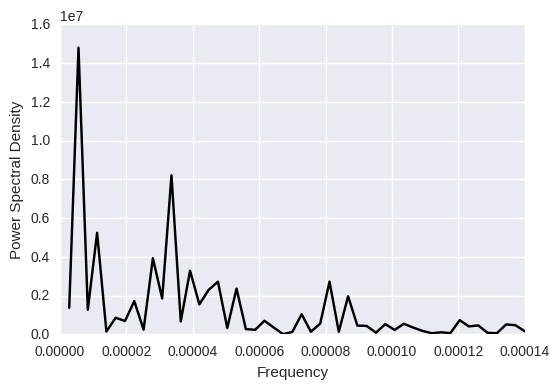

In [480]:
fft_signal = np.fft.fft(noise)
freq = np.fft.fftfreq(len(noise))

freq_ind = np.arange(1, len(fft_signal)/2, dtype=int)
#print np.allclose(f[freq_ind], -1 * f[-freq_ind]) # Make sure the Frequencies are mirrored

#calculate power spectral density
psd = np.abs(fft_signal[freq_ind])**2

plt.figure()
plt.plot(freq[freq_ind[:50]], psd[:50], 'k-')
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.show()

In [481]:
noise[50000:150000].mean()

0.00312

In [482]:
noise[250000:300000].mean()

0.00184